In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xgboost
import xarray as xr
import numpy as np
from dask.distributed import Client
import dask
import dask_xgboost
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow

In [3]:
processed_path = '/media/scottcha/Data/Temp/GFSFiltered/'
path_to_labels = '/media/scottcha/E1/Data/OAPMLData/CleanedForecastsNWAC_CAIC_UAC.V1.csv'

In [4]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [5]:
#TODO set memory limit lower, then optimize chunks
client=Client(n_workers=8, threads_per_worker=1 )
client

Client Scheduler: tcp://127.0.0.1:46359 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 50.55 GB


In [6]:
def lookup_forecast_region(label_region):
    if label_region == 'Mt Hood':
        return 'Mt Hood'
    elif label_region == 'Olympics':
        return 'Olympics'
    elif label_region == 'Cascade Pass - Snoq. Pass':
        return 'Snoqualmie Pass'
    elif label_region == 'Cascade Pass - Stevens Pass':
        return 'Stevens Pass'
    elif label_region == 'Cascade East - Central':
        return 'WA Cascades East, Central'
    elif label_region == 'Cascade East - North':
        return 'WA Cascades East, North'
    elif label_region == 'Cascade East - South':
        return 'WA Cascades East, South'
    elif label_region == 'Cascade West - Central':
        return 'WA Cascades West, Central'
    elif label_region == 'Cascade West - North':
        return 'WA Cascades West, Mt Baker'
    elif label_region == 'Cascade West - South':
        return 'WA Cascades West, South'
    elif label_region == 'Abajo':
        return 'Abajos'
    elif label_region == 'Logan':
        return 'Logan'
    elif label_region == 'Moab':
        return 'Moab'
    elif label_region == 'Ogden':
        return 'Ogden'
    elif label_region == 'Provo':
        return 'Provo'
    elif label_region == 'Salt Lake':
        return 'Salt Lake'
    elif label_region == 'Skyline':
        return 'Skyline'
    elif label_region == 'Uintas':
        return 'Uintas'
    elif label_region == 'Grand Mesa':
        return 'Grand Mesa Zone'
    elif label_region == 'Sangre de Cristo':
        return 'Sangre de Cristo Range'
    elif label_region == 'Steamboat & Flat Tops':
        return 'Steamboat Zone'
    elif label_region == 'Front Range':
        return 'Front Range Zone'
    elif label_region == 'Vail & Summit County':
        return 'Vail Summit Zone'
    elif label_region == 'Sawatch Range':
        return 'Sawatch Zone'
    elif label_region == 'Aspen':
        return 'Aspen Zone'
    elif label_region == 'Northern San Juan':
        return 'North San Juan Mountains'
    elif label_region == 'Southern San Juan':
        return 'South San Juan Mountains'
    elif label_region == 'Gunnison':
        return 'Gunnison Zone'
    else:
        return 'Unknown region'

In [7]:
regions = ['Abajos', 'Logan', 'Moab', 'Ogden', 'Provo', 
           'Salt Lake', 'Skyline', 'Uintas', 'Grand Mesa Zone', 
           'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
           'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
           'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone',
           'Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass',
           'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South',
           'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'
           ]

In [21]:
#maintaining this as a dict since the arrays are ragged and its more efficient this way
region_data = {}
for r in regions:
    region_data[r] = xr.open_mfdataset('/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_' + r + '*.nc', combine='nested', concat_dim='time', chunks={'season': 1, 'region': -1, 'latitude': 2, 'longitude': 2, 'var': -1, 'time': -1}).to_array()
    

/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 11
  **blockwise_kwargs,
/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 11
  **blockwise_kwargs,
/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs,
/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs,
/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:3903: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/dask/array/core.py:

In [11]:
region_data['Olympics']

<xarray.DataArray 'stack-54c9bc9566203695444d67e3992488c5' (variable: 1, season: 2, region: 1, latitude: 19, longitude: 30, var: 810, time: 730)>
dask.array<stack, shape=(1, 2, 1, 19, 30, 810, 730), dtype=float32, chunksize=(1, 2, 1, 4, 4, 810, 365), chunktype=numpy.ndarray>
Coordinates:
  * var        (var) object "(0, 'level_depthBelowLandLayer_avg_soilw')" ... 'level_unknown_min_v'
  * longitude  (longitude) float64 236.1 236.1 236.2 236.2 ... 236.9 237.0 237.0
  * latitude   (latitude) float64 47.51 47.53 47.57 47.59 ... 47.99 48.01 48.04
  * region     (region) object 'Olympics'
  * season     (season) object '15-16' '16-17'
  * time       (time) datetime64[ns] 2015-05-02 2015-05-03 ... 2017-04-30
  * variable   (variable) <U29 '__xarray_dataarray_variable__'

In [11]:
labels = pd.read_csv(path_to_labels, low_memory=False,
        dtype={'Day1Danger_OctagonAboveTreelineEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorth': 'object',
               'Day1Danger_OctagonAboveTreelineNorthEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorthWest': 'object',
               'Day1Danger_OctagonAboveTreelineSouth': 'object',
               'Day1Danger_OctagonAboveTreelineSouthEast': 'object',
               'Day1Danger_OctagonAboveTreelineSouthWest': 'object',
               'Day1Danger_OctagonAboveTreelineWest': 'object',
               'Day1Danger_OctagonBelowTreelineEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorth': 'object',
               'Day1Danger_OctagonBelowTreelineNorthEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorthWest': 'object',
               'Day1Danger_OctagonBelowTreelineSouth': 'object',
               'Day1Danger_OctagonBelowTreelineSouthEast': 'object',
               'Day1Danger_OctagonBelowTreelineSouthWest': 'object',
               'Day1Danger_OctagonBelowTreelineWest': 'object',
               'Day1Danger_OctagonNearTreelineEast': 'object',
               'Day1Danger_OctagonNearTreelineNorth': 'object',
               'Day1Danger_OctagonNearTreelineNorthEast': 'object',
               'Day1Danger_OctagonNearTreelineNorthWest': 'object',
               'Day1Danger_OctagonNearTreelineSouth': 'object',
               'Day1Danger_OctagonNearTreelineSouthEast': 'object',
               'Day1Danger_OctagonNearTreelineSouthWest': 'object',
               'Day1Danger_OctagonNearTreelineWest': 'object',
               'SpecialStatement': 'object',
               'image_paths': 'object',
               'image_types': 'object',
               'image_urls': 'object'})
date_col = 'Day1Date'
region_col = 'UnifiedRegion'
labels['parsed_date'] = pd.to_datetime(labels[date_col], format='%Y%m%d')
parsed_date_col = 'parsed_date'
metadata_cols = [date_col, region_col]
label_cols = ['Day1DangerBelowTreeline', 'Day1DangerNearTreeline', 'Day1DangerAboveTreeline']
labels[region_col] = labels.apply(lambda x : lookup_forecast_region(x[region_col]), axis=1)
labels = labels[labels[region_col]!='Unknown region']

In [12]:
#this demonstrates wihtin a region how much data we have versus masked out areas
region_data['Steamboat Zone'].isel(var=2, time=300, season=0).plot()

NameError: name 'region_data' is not defined

In [22]:
#find union of all lat/lon/region
#the process to filter the lat/lon is expensive but we need to do it here (1-2 mins per region)
#as the helps the batch process select relevant data
lat_lon_union = pd.DataFrame()
for r in region_data.keys():
    print(r)
    region_df = region_data[r].stack(lat_lon_region = ('latitude', 'longitude', 'region')).lat_lon_region.to_dataframe()
    tmp_df = pd.DataFrame.from_records(region_df['lat_lon_region'], columns=['latitude', 'longitude', region_col])
    indexes_to_drop = []
    for index, row in tmp_df.iterrows():
        #TODO: there might be a more efficient way than doing this one by one?
        if 0 == np.count_nonzero(region_data[r].sel(latitude=row['latitude'], longitude=row['longitude']).stack(time_var = ('season','time', 'var')).dropna(dim='time_var', how='all').values):
            indexes_to_drop.append(index)
    tmp_df.drop(indexes_to_drop, axis=0, inplace=True)
    lat_lon_union = pd.concat([lat_lon_union, tmp_df])

Abajos
Logan
Moab
Ogden
Provo
Salt Lake
Skyline
Uintas
Grand Mesa Zone
Sangre de Cristo Range
Steamboat Zone
Front Range Zone
Vail Summit Zone
Sawatch Zone
Aspen Zone
North San Juan Mountains
South San Juan Mountains
Gunnison Zone
Mt Hood
Olympics
Snoqualmie Pass
Stevens Pass
WA Cascades East, Central
WA Cascades East, North
WA Cascades East, South
WA Cascades West, Central
WA Cascades West, Mt Baker
WA Cascades West, South


In [25]:
#cache the data
lat_lon_union.to_csv('/media/scottcha/Data/Temp/GFSFiltered/lat_lon_union.csv')

In [13]:
lat_lon_union = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/lat_lon_union.csv',float_precision='round_trip')

In [14]:
lat_lon_union.shape

(5445, 4)

In [15]:
lat_lon_union = lat_lon_union.set_index(region_col, drop=False).join(labels.set_index(region_col, drop=False), how='left', lsuffix='left', rsuffix='right')

In [13]:
lat_lon_union.shape

(3791777, 296)

In [16]:
del labels

In [17]:
def date_to_season(d):
    if d >= np.datetime64('2014-11-01') and d <= np.datetime64('2015-04-30'):
        return '14-15'
    elif d >= np.datetime64('2015-11-01') and d <= np.datetime64('2016-04-30'):
        return '15-16'
    elif d >= np.datetime64('2016-11-01') and d <= np.datetime64('2017-04-30'):
        return '16-17'
    elif d >= np.datetime64('2017-11-01') and d <= np.datetime64('2018-04-30'):
        return '17-18'
    elif d >= np.datetime64('2018-11-01') and d <= np.datetime64('2019-04-30'):
        return '18-19'
    elif d >= np.datetime64('2019-11-01') and d <= np.datetime64('2020-04-30'):
        return '19-20'
    else:
        print('Unknown season ' + str(d))
        return 'Unknown'
    

In [22]:
#remove unnecessary dimensions (like region)
for k in region_data.keys():
    region_data[k] = region_data[k].squeeze()

In [23]:

def get_xr_batch(all_data, labels, lookback_days=14, batch_size=64, y_column='Day1DangerAboveTreeline'):
    labels_data = labels
    
    X = None     
    y = None 

    first = True
    first_y = True
    num_in_place = 0
    
    while num_in_place < batch_size:
        if not first:
            #if we didn't meet the full batch size 
            #continue appending until its full
            #if num_in_place % 5 == 0:
            print('Filling remaining have ' + str(num_in_place))
            sample_size = batch_size-num_in_place
            if sample_size < 4:
                sample_size = 4
        else: 
            sample_size = batch_size
        
        #get 1/4 of the data from 'High' and 1/4 from low
        #this is basically a naive oversampling strategy since Low/High 
        #populations are much smaller that moderate/considerable
        #TODO: add Extreme in (or possibly make it high)
        batch_lookup_low = labels_data[labels_data[y_column]=='Low'].sample(int(sample_size/4), random_state=1)
        batch_lookup_moderate = labels_data[labels_data[y_column]=='Moderate'].sample(int(sample_size/4), random_state=1)
        batch_lookup_considerable = labels_data[labels_data[y_column]=='Considerable'].sample(int(sample_size/4), random_state=1)
        batch_lookup_high = labels_data[labels_data[y_column]=='High'].sample(int(sample_size/4), random_state=1)
        
        #remove moderate and considerable 
        labels_data = labels_data.drop(batch_lookup_moderate.index, axis=0)
        labels_data = labels_data.drop(batch_lookup_considerable.index, axis=0)
        
        #sample frac=1 causes the data to be shuffled
        batch_lookup = pd.concat([batch_lookup_low,batch_lookup_moderate,batch_lookup_considerable,batch_lookup_high]).sample(frac=1)
        for _, row in batch_lookup.iterrows():
            d = row[parsed_date_col]
            lat = row['latitude']
            lon = row['longitude']
            reg = row[region_col]            
            #TODO: would be nice and improve perf if we could get all the lat/lon from a region at once
            season = date_to_season(d)            
            data = all_data[reg].sel(latitude=lat, longitude=lon, season=season).sel(time = slice(d + np.timedelta64(-1 * lookback_days, 'D'), d))
            #reset the time index so we can align when concating
            data = data.reset_index(dims_or_levels='time', drop=True)
            if data.time.shape[0]-1 != lookback_days:                
                batch_lookup = batch_lookup.drop(_, axis=0)
                continue

            #this is a serious perf penalty, need to figure out a better way to do this
            #while keeping X and y aligned            
            tmp = data.values.copy()            
            tmp[tmp==0] = np.nan #in some cases there is only 0 data, setting 0 to nan to filter
            if np.isnan(tmp).all():
                #clean up any values which are all nan
                batch_lookup = batch_lookup.drop(_, axis=0)
                continue
            
            #data = data.drop_dims(['region', 'season'])
            if first:
                X = data
                first = False        
            else:
                X = xr.concat([X, data], dim='sample')
        
        if first_y:
            y = batch_lookup
            first_y = False
        else:
            y = pd.concat([y, batch_lookup], axis=0)
        num_in_place = y.shape[0]
                
    y = y.reset_index(drop=True)
            
    return X, y, labels_data







In [24]:
date_min = np.datetime64('2015-11-01')
date_max = np.datetime64('2017-04-30')
train_date_cutoff = np.datetime64('2016-04-30')


In [25]:
labels_data_union = lat_lon_union[lat_lon_union[parsed_date_col] >= date_min]
labels_data_union = labels_data_union[labels_data_union[parsed_date_col] <= date_max]
#copy so we can delete the overall data and only keep the filtered
labels_data_train = labels_data_union[labels_data_union[parsed_date_col] <= train_date_cutoff].copy()
labels_data_test = labels_data_union[labels_data_union[parsed_date_col] > train_date_cutoff].copy()


In [26]:
labels_data_train.reset_index(inplace=True)
labels_data_test.reset_index(inplace=True)

In [27]:
labels_data_train.shape

(764822, 297)

In [28]:
del lat_lon_union

In [29]:
import gc
gc.collect()

31

In [24]:
%time X_train, y_train, remaining_labels_train = get_xr_batch(region_data, labels_data_train, 180, 512)

Filling remaining have 387
Filling remaining have 471
Filling remaining have 503
Filling remaining have 506
Filling remaining have 508
Filling remaining have 510
Filling remaining have 511
CPU times: user 1min 46s, sys: 13.4 s, total: 1min 59s
Wall time: 2min 26s


In [26]:
X_train

<xarray.DataArray 'stack-b5c21a027fa0e206946a4b4f2c426b3e' (sample: 512, var: 810, time: 181)>
dask.array<vectorize_func_interpolate_na, shape=(512, 810, 181), dtype=float32, chunksize=(1, 810, 181), chunktype=numpy.ndarray>
Coordinates:
    season     <U5 '15-16'
    variable   <U29 '__xarray_dataarray_variable__'
  * var        (var) object "(0, 'level_depthBelowLandLayer_avg_soilw')" ... 'level_unknown_min_v'
    latitude   (sample) float64 37.58 48.76 39.17 38.68 ... 37.64 37.64 37.64
    longitude  (sample) float64 252.0 239.8 253.4 254.8 ... 252.0 252.0 252.0
    region     (sample) <U26 'South San Juan Mountains' ... 'North San Juan Mountains'
Dimensions without coordinates: sample, time

In [27]:
X_train.shape

(512, 810, 181)

In [28]:
y_train['Day1DangerAboveTreeline'].shape

(512,)

In [77]:
labels_data_train.shape

(764822, 297)

In [78]:
remaining_labels_train.shape

(764132, 297)

In [37]:
X_train.nbytes

75064320

In [58]:
X_train

<xarray.DataArray 'stack-ea169a3d29dad35e6e2a49c16bd15a5e' (sample: 256, var: 810, time: 181)>
dask.array<concatenate, shape=(256, 810, 181), dtype=float32, chunksize=(1, 810, 181), chunktype=numpy.ndarray>
Coordinates:
    variable   <U29 '__xarray_dataarray_variable__'
    season     <U5 '15-16'
  * var        (var) object "(0, 'level_depthBelowLandLayer_avg_soilw')" ... 'level_unknown_min_v'
    longitude  (sample) float64 252.4 254.4 248.8 254.5 ... 248.4 254.0 254.3
    latitude   (sample) float64 38.98 39.47 39.17 40.93 ... 41.11 39.9 39.35
    region     (sample) <U24 'Grand Mesa Zone' ... 'Front Range Zone'
Dimensions without coordinates: sample, time

In [59]:
labels_data_test.head()

,UnifiedRegion,Unnamed: 0,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,...,WindSlab_OctagonNearTreelineNorthWest,WindSlab_OctagonNearTreelineSouth,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date
0,Abajos,1,37.704348,250.223464,Abajos,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,full/c74aa21a401ef9c42e3ee835fd229ce5d3f9b367....,"Forecast,",https://utahavalanchecenter.org/sites/default/...,NaN,2016-12-03
1,Abajos,1,37.704348,250.223464,Abajos,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,full/87889967c3f5a0c6da2b95e0342bec1dd2fab16f....,"Forecast,",https://utahavalanchecenter.org/sites/default/...,NaN,2016-12-04
2,Abajos,1,37.704348,250.223464,Abajos,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,full/76ffa189cee1fc1a57e3d4790c1247dca09ea38b....,"Forecast,",https://utahavalanchecenter.org/sites/default/...,NaN,2016-12-05
3,Abajos,1,37.704348,250.223464,Abajos,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,full/4fcd04dac5c10ba4839809e885670222ade2b27e....,"Forecast,",https://utahavalanchecenter.org/sites/default/...,NaN,2016-12-07
4,Abajos,1,37.704348,250.223464,Abajos,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,full/f207156265f4a2c2c26554380fab3eb04a5e04a2....,"Forecast,",https://utahavalanchecenter.org/sites/default/...,NaN,2016-12-09


In [30]:
%time X_test, y_test, remaining_labels_test = get_xr_batch(region_data, labels_data_test, lookback_days=180, batch_size=512)

Filling remaining have 366
Filling remaining have 474
Filling remaining have 501
Filling remaining have 506
Filling remaining have 509
CPU times: user 1min 29s, sys: 11.7 s, total: 1min 41s
Wall time: 2min 16s


In [31]:
X_train = X_train.interpolate_na('time')
X_test = X_test.interpolate_na('time')


In [32]:
def xr_batch_to_tsfresh_df(xr_batch):
    xr_batch = xr_batch.dropna(dim='var', how='all')
    stacked = xr_batch.stack(tsdata=('sample', 'time', 'var')).to_dataframe().iloc[:,[-1]]
    stacked.columns = ['value']
    stacked.reset_index(inplace=True)
    stacked.columns = ['id', 'time', 'kind', 'value']
    stacked.dropna(how='any', inplace=True)
    return stacked

In [27]:
%time tsfresh_data = xr_batch_to_tsfresh_df(X_train)

CPU times: user 46.5 s, sys: 11.5 s, total: 58 s
Wall time: 1min 1s


In [33]:
%time tsfresh_data_test = xr_batch_to_tsfresh_df(X_test)

CPU times: user 47.2 s, sys: 11 s, total: 58.2 s
Wall time: 1min 1s


In [29]:
tsfresh_data.to_csv('/media/scottcha/Data/Temp/GFSFiltered/training_tsfresh_data.csv')
y_train.to_csv('/media/scottcha/Data/Temp/GFSFiltered/y_train.csv')

In [34]:
tsfresh_data_test.to_csv('/media/scottcha/Data/Temp/GFSFiltered/test_tsfresh_data.csv')
y_test.to_csv('/media/scottcha/Data/Temp/GFSFiltered/y_test.csv')

In [1]:
import pandas as pd
tsfresh_data = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/training_tsfresh_data.csv')
y_train = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_train.csv')

In [25]:
y_train = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_train.csv')

In [1]:
import pandas as pd
tsfresh_data_test = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/test_tsfresh_data.csv')
y_test = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_test.csv')

In [26]:
y_test = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_test.csv')

In [2]:
import numpy as np
np.isnan(tsfresh_data['value']).any()

False

In [2]:
tsfresh_data = tsfresh_data[['id', 'time', 'kind', 'value']]

In [9]:
tsfresh_data.shape

(66555078, 4)

In [6]:
len(tsfresh_data['kind'].unique())

735

In [8]:
tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].values[0:50])]

,id,time,kind,value
0,0,0,"(0, 'level_depthBelowLandLayer_avg_soilw')",0.000000
1,0,0,"(0, 'level_depthBelowLandLayer_avg_st')",0.000000
2,0,0,"(0, 'level_depthBelowLandLayer_max_soilw')",0.000000
3,0,0,"(0, 'level_depthBelowLandLayer_max_st')",0.000000
4,0,0,"(0, 'level_depthBelowLandLayer_min_soilw')",0.000000
...,...,...,...,...
66554468,511,180,"(150, 'level_isobaricInhPa_min_r')",2.229109
66554469,511,180,"(150, 'level_isobaricInhPa_min_t')",213.158340
66554470,511,180,"(150, 'level_isobaricInhPa_min_u')",15.767248
66554471,511,180,"(150, 'level_isobaricInhPa_min_v')",-23.473888


In [6]:
tsfresh_data['id'].value_counts()

123    133017
317    132735
82     132615
119    132603
118    132585
        ...  
277    126522
272    126522
377    126522
279    126327
169    126261
Name: id, Length: 512, dtype: int64

In [3]:
from tsfresh import extract_relevant_features

In [4]:
relevant_features =[]

In [5]:
stride = 75
#TODO: make this more gracefully end on last stride
for i in range(0,len(tsfresh_data['kind'].values),stride):
    print('On i: ' + str(i))
    relevant_features.append( extract_relevant_features(tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].unique()[i:i+stride])], y_train['Day1DangerAboveTreeline'], column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))

On i: 0


Feature Extraction: 100%|██████████| 70/70 [10:56<00:00,  9.38s/it]  


On i: 75


Feature Extraction: 100%|██████████| 70/70 [10:25<00:00,  8.94s/it]  


On i: 150


Feature Extraction: 100%|██████████| 70/70 [09:05<00:00,  7.79s/it]  


On i: 225


Feature Extraction: 100%|██████████| 70/70 [11:00<00:00,  9.43s/it]  


On i: 300


Feature Extraction: 100%|██████████| 70/70 [11:05<00:00,  9.51s/it]  


On i: 375


Feature Extraction: 100%|██████████| 70/70 [11:01<00:00,  9.45s/it]  


On i: 450


Feature Extraction: 100%|██████████| 70/70 [10:56<00:00,  9.37s/it]  


On i: 525


Feature Extraction: 100%|██████████| 70/70 [11:04<00:00,  9.49s/it]  


On i: 600


Feature Extraction: 100%|██████████| 70/70 [11:00<00:00,  9.43s/it]  


On i: 675


Feature Extraction: 100%|██████████| 70/70 [08:42<00:00,  7.47s/it] 


On i: 750


ValueError: The following ids are in y but are missing inside the time series container: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511}

In [29]:
speak('done')

In [16]:
pd.concat(relevant_features, axis=1).to_csv('/media/scottcha/Data/Temp/GFSFiltered/train_revelant_features.csv')

In [3]:
relevant_features = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/train_revelant_features.csv')

In [9]:
relevant_features.drop('id', axis=1, inplace=True)

In [35]:
y_train['Day1DangerAboveTreeline'].value_counts()

Moderate        137
Considerable     53
Low              41
no-data          16
High              7
Name: Day1DangerAboveTreeline, dtype: int64

In [11]:
from tsfresh import feature_extraction
feature_parameters = feature_extraction.settings.from_columns(relevant_features)

In [93]:
X_test.shape

(128, 735, 181)

In [94]:
tsfresh_data_test['id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [13]:
from tsfresh import extract_features
stride = 75
test_features_filtered = []
for i in range(0,len(tsfresh_data_test['kind'].values),stride):
    print('On i: ' + str(i))
    test_features_filtered.append( extract_features(tsfresh_data_test[tsfresh_data_test['kind'].isin(tsfresh_data_test['kind'].unique()[i:i+stride])], kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))


On i: 0


Feature Extraction: 100%|██████████| 70/70 [08:06<00:00,  6.95s/it] 


On i: 75


Feature Extraction: 100%|██████████| 70/70 [07:21<00:00,  6.30s/it] 


On i: 150


Feature Extraction: 100%|██████████| 70/70 [05:21<00:00,  4.59s/it] 


On i: 225


Feature Extraction: 100%|██████████| 70/70 [10:06<00:00,  8.66s/it]  


On i: 300


Feature Extraction: 100%|██████████| 70/70 [08:08<00:00,  6.98s/it] 


On i: 375


Feature Extraction: 100%|██████████| 70/70 [08:01<00:00,  6.88s/it] 


On i: 450


Feature Extraction: 100%|██████████| 70/70 [09:30<00:00,  8.15s/it]  


On i: 525


Feature Extraction: 100%|██████████| 70/70 [09:53<00:00,  8.48s/it]  


On i: 600


Feature Extraction: 100%|██████████| 70/70 [09:08<00:00,  7.83s/it]  


On i: 675


Feature Extraction: 100%|██████████| 70/70 [06:47<00:00,  5.83s/it] 


On i: 750


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [19]:
test_features_filtered = pd.concat(test_features_filtered, axis=1)

In [14]:
pd.concat(test_features_filtered, axis=1).to_csv('/media/scottcha/Data/Temp/GFSFiltered/test_revelant_features.csv')

In [15]:
import xgboost as xgb
from xgboost import XGBClassifier

In [23]:
features_filtered = relevant_features

In [59]:
relevant_intersection = list(set(test_features_filtered.columns.values) & set(features_filtered.columns.values))

In [61]:
features_filtered[relevant_intersection].shape

(512, 234983)

In [60]:
grid = {'learning_rate': 0.1, 'objective': 'multi:softmax'}

model = XGBClassifier() 
model.set_params(**grid)



XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [62]:
val = model.fit(features_filtered[relevant_intersection], y_train['Day1DangerAboveTreeline'])

In [63]:
result = model.predict(test_features_filtered[relevant_intersection])

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
result.shape

(512,)

In [66]:
y_test['Day1DangerAboveTreeline'].shape

(512,)

In [67]:
#demonstrate we can produce results
#currently this is only one batch of 512 out of a close to a million row dataset
evaluateSingleClassShort(y_test['Day1DangerAboveTreeline'], result)

Accuracy: 0.51171875
Classification Report
              precision    recall  f1-score   support

Considerable       0.41      0.47      0.44       110
        High       0.64      0.36      0.46       100
         Low       0.64      0.68      0.66       171
    Moderate       0.39      0.44      0.41       131

    accuracy                           0.51       512
   macro avg       0.52      0.49      0.49       512
weighted avg       0.53      0.51      0.51       512



Normalized confusion matrix
Confusion matrix, without normalization


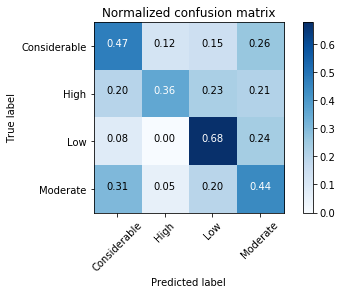

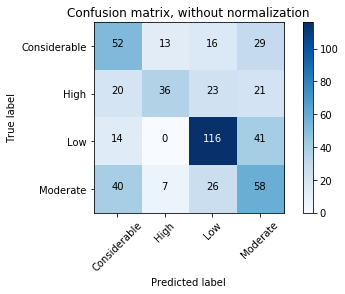

In [69]:
import numpy as np
cnf_matrix = confusion_matrix(y_test['Day1DangerAboveTreeline'], result)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

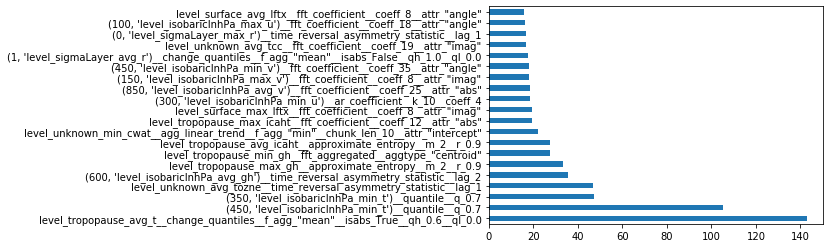

In [87]:
pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)[:20].plot.barh()